In [43]:
from bayesian_model import GPSparseBayesModel
from data_loader import data_loader
from utils import ause, return_replicates
from utils import permutation_test_ause
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd

In [26]:
datasets = data_loader()

In [46]:
def run_simulation(dataset, kernel, loss, ind):
    X, y = datasets[dataset]
    replicates = return_replicates(X, y)
    for X_train, X_test, y_train, y_test in replicates:
        model = GPSparseBayesModel(**{"random_seed": 7200, 
                                      "induced_points_method": "random", 
                                      "num_induced_samples": 'sqrt', 
                                      "kernel": kernel,
                                      "loss": loss,
                                      "induced_points_method": ind
                                    })
        model.after_setup()
        X_train, X_test = np.array(X_train), np.array(X_test)
        y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()
        model.train(X_train, y_train)
        pred_probs, pred_var, pred_labels = model.test(X_test, None)
        accuracy = accuracy_score(y_test, np.where(pred_probs > 0.5, 1, 0))
        f1 = f1_score(y_test, np.where(pred_probs > 0.5, 1, 0))
        pred_ause = ause(pred_probs, pred_var, pred_labels)[0]
        results['dataset'].append(dataset)
        results['kernel'].append(kernel)
        results['loss'].append(loss)
        results['induction_method'].append(ind)
        results['ause'].append(pred_ause)
        results['accuracy'].append(accuracy)
        results['f1'].append(f1)
        print(pred_ause, accuracy, f1, ind, kernel, loss, dataset)

In [47]:
kernels = ['rbf', 'linear', 'poly']
losses = ['trace_elbo', 'trace_meanfield_elbo']
induced_points_methods = ['kmeans', 'random']
dataset_names = list(datasets.keys())

results = {
    'dataset': [],
    'kernel': [],
    'induction_method': [],
    'loss': [],
    'ause': [],
    'ece': [],
    'accuracy': [],
    'f1': []
}

for dataset, kernel, loss, ind in itertools.product(dataset_names, kernels, losses, induced_points_methods):
    run_simulation(dataset, kernel, loss, ind)

0.1344297454422012 0.7083333333333334 0.5172413793103449 kmeans rbf trace_elbo diabetes
0.12327215038375086 0.78125 0.6666666666666667 kmeans rbf trace_elbo diabetes
2.6293304765223615e-07 0.3854166666666667 0.5203252032520325 random rbf trace_elbo diabetes
0.2481121763378918 0.75 0.5714285714285715 random rbf trace_elbo diabetes
0.0 0.3333333333333333 0.5 kmeans rbf trace_meanfield_elbo diabetes
0.0 0.6458333333333334 0.0 kmeans rbf trace_meanfield_elbo diabetes
0.131677381614508 0.7395833333333334 0.5454545454545454 random rbf trace_meanfield_elbo diabetes
0.13057467732278394 0.7395833333333334 0.5283018867924527 random rbf trace_meanfield_elbo diabetes
0.001559995308136428 0.5833333333333334 0.31034482758620696 kmeans linear trace_elbo diabetes
0.0026584832798251185 0.3958333333333333 0.3255813953488372 kmeans linear trace_elbo diabetes
0.007346324210925971 0.4270833333333333 0.45544554455445535 random linear trace_elbo diabetes
0.0033477964168897173 0.5104166666666666 0.29850746268

0.002300268173613539 0.6949429037520392 0.21757322175732216 random poly trace_elbo white-wine
0.00865434280573501 0.734094616639478 0.47249190938511326 kmeans poly trace_meanfield_elbo white-wine
0.009185330182822759 0.7373572593800979 0.482315112540193 kmeans poly trace_meanfield_elbo white-wine
0.009703338456743971 0.7814029363784666 0.21176470588235297 random poly trace_meanfield_elbo white-wine
0.019226146742108714 0.763458401305057 0.19889502762430938 random poly trace_meanfield_elbo white-wine


In [48]:
del results['ece']
simulation_runs = pd.DataFrame.from_dict(results)
simulation_runs

,dataset,kernel,induction_method,loss,ause,accuracy,f1
0,diabetes,rbf,kmeans,trace_elbo,1.344297e-01,0.708333,0.517241
1,diabetes,rbf,kmeans,trace_elbo,1.232722e-01,0.781250,0.666667
2,diabetes,rbf,random,trace_elbo,2.629330e-07,0.385417,0.520325
3,diabetes,rbf,random,trace_elbo,2.481122e-01,0.750000,0.571429
4,diabetes,rbf,kmeans,trace_meanfield_elbo,0.000000e+00,0.333333,0.500000
...,...,...,...,...,...,...,...
91,white-wine,poly,random,trace_elbo,2.300268e-03,0.694943,0.217573
92,white-wine,poly,kmeans,trace_meanfield_elbo,8.654343e-03,0.734095,0.472492
93,white-wine,poly,kmeans,trace_meanfield_elbo,9.185330e-03,0.737357,0.482315
94,white-wine,poly,random,trace_meanfield_elbo,9.703338e-03,0.781403,0.211765


In [82]:
simulation_runs.to_csv('simulation_runs.csv')

In [49]:
from scipy.stats import t, f, sem
from bioinfokit.analys import stat
import statsmodels.api as sm
from statsmodels.formula.api import ols

diabetes = simulation_runs.loc[simulation_runs['dataset']=='diabetes']
ionosphere = simulation_runs.loc[simulation_runs['dataset']=='ionosphere']
red_wine = simulation_runs.loc[simulation_runs['dataset']=='red-wine']
white_wine = simulation_runs.loc[simulation_runs['dataset']=='white-wine']

In [70]:
diabetes_model = ols('accuracy~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=diabetes).fit()
sm.stats.anova_lm(diabetes_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.040591,0.020295,1.334027,0.299814
C(loss),1.0,0.057730,0.057730,3.794651,0.075191
C(induction_method),1.0,0.000366,0.000366,0.024071,0.879283
C(kernel):C(loss),2.0,0.071135,0.035568,2.337890,0.138858
C(kernel):C(induction_method),2.0,0.004910,0.002455,0.161367,0.852796
C(loss):C(induction_method),1.0,0.068400,0.068400,4.495988,0.055498
C(kernel):C(loss):C(induction_method),2.0,0.035021,0.017510,1.150966,0.348915
Residual,12.0,0.182563,0.015214,NaN,NaN


In [73]:
ionosphere_model = ols('accuracy~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=ionosphere).fit()
sm.stats.anova_lm(ionosphere_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.019929,0.009965,5.578313,0.019366
C(loss),1.0,0.001055,0.001055,0.590361,0.457134
C(induction_method),1.0,0.001055,0.001055,0.590361,0.457134
C(kernel):C(loss),2.0,0.005725,0.002862,1.602410,0.241657
C(kernel):C(induction_method),2.0,0.003917,0.001959,1.096386,0.365329
C(loss):C(induction_method),1.0,0.000194,0.000194,0.108434,0.747611
C(kernel):C(loss):C(induction_method),2.0,0.008652,0.004326,2.421687,0.130771
Residual,12.0,0.021436,0.001786,NaN,NaN


In [76]:
red_wine_model = ols('accuracy~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=red_wine).fit()
sm.stats.anova_lm(red_wine_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.000477,0.000239,0.157931,0.855655
C(loss),1.0,0.075938,0.075938,50.275862,0.000013
C(induction_method),1.0,0.002817,0.002817,1.864828,0.197120
C(kernel):C(loss),2.0,0.034331,0.017166,11.364828,0.001702
C(kernel):C(induction_method),2.0,0.016265,0.008132,5.384138,0.021434
C(loss):C(induction_method),1.0,0.005104,0.005104,3.379310,0.090888
C(kernel):C(loss):C(induction_method),2.0,0.001327,0.000664,0.439310,0.654442
Residual,12.0,0.018125,0.001510,NaN,NaN


In [79]:
white_wine_model = ols('accuracy~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=white_wine).fit()
sm.stats.anova_lm(white_wine_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.106622,0.053311,6.192146,0.014205
C(loss),1.0,0.143095,0.143095,16.620679,0.001535
C(induction_method),1.0,0.000128,0.000128,0.014888,0.904904
C(kernel):C(loss),2.0,0.072168,0.036084,4.191219,0.041644
C(kernel):C(induction_method),2.0,0.001785,0.000892,0.103640,0.902348
C(loss):C(induction_method),1.0,0.002910,0.002910,0.338004,0.571743
C(kernel):C(loss):C(induction_method),2.0,0.001930,0.000965,0.112089,0.894890
Residual,12.0,0.103313,0.008609,NaN,NaN


In [71]:
diabetes_model = ols('ause~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=diabetes).fit()
sm.stats.anova_lm(diabetes_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.042631,0.021315,8.281386,0.005499
C(loss),1.0,0.001454,0.001454,0.564981,0.466747
C(induction_method),1.0,0.002990,0.002990,1.161638,0.302316
C(kernel):C(loss),2.0,0.006196,0.003098,1.203697,0.333868
C(kernel):C(induction_method),2.0,0.005005,0.002502,0.972247,0.406136
C(loss):C(induction_method),1.0,0.003118,0.003118,1.211372,0.292649
C(kernel):C(loss):C(induction_method),2.0,0.006134,0.003067,1.191630,0.337243
Residual,12.0,0.030887,0.002574,NaN,NaN


In [74]:
ionosphere_model = ols('ause~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=ionosphere).fit()
sm.stats.anova_lm(ionosphere_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.033993,0.016996,9.436722,0.003448
C(loss),1.0,0.000343,0.000343,0.190492,0.670256
C(induction_method),1.0,0.005550,0.005550,3.081487,0.104658
C(kernel):C(loss),2.0,0.006919,0.003460,1.920790,0.188928
C(kernel):C(induction_method),2.0,0.000520,0.000260,0.144331,0.867082
C(loss):C(induction_method),1.0,0.002133,0.002133,1.184121,0.297891
C(kernel):C(loss):C(induction_method),2.0,0.001144,0.000572,0.317598,0.733830
Residual,12.0,0.021613,0.001801,NaN,NaN


In [77]:
red_wine_model = ols('ause~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=red_wine).fit()
sm.stats.anova_lm(red_wine_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.308038,0.154019,60.344829,5.470979e-07
C(loss),1.0,0.000035,0.000035,0.013547,9.092660e-01
C(induction_method),1.0,0.006623,0.006623,2.594962,1.331782e-01
C(kernel):C(loss),2.0,0.000374,0.000187,0.073174,9.298508e-01
C(kernel):C(induction_method),2.0,0.012076,0.006038,2.365698,1.361114e-01
C(loss):C(induction_method),1.0,0.002079,0.002079,0.814727,3.844868e-01
C(kernel):C(loss):C(induction_method),2.0,0.004069,0.002035,0.797157,4.730900e-01
Residual,12.0,0.030628,0.002552,NaN,NaN


In [80]:
white_wine_model = ols('ause~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=white_wine).fit()
sm.stats.anova_lm(white_wine_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.966576,0.483288,1103.098109,2.506615e-14
C(loss),1.0,0.000006,0.000006,0.012851,9.116165e-01
C(induction_method),1.0,0.000083,0.000083,0.189905,6.707321e-01
C(kernel):C(loss),2.0,0.000343,0.000171,0.391239,6.845374e-01
C(kernel):C(induction_method),2.0,0.000231,0.000116,0.264168,7.721955e-01
C(loss):C(induction_method),1.0,0.000004,0.000004,0.009341,9.246000e-01
C(kernel):C(loss):C(induction_method),2.0,0.000159,0.000079,0.181217,8.364957e-01
Residual,12.0,0.005257,0.000438,NaN,NaN


In [72]:
diabetes_model = ols('f1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=diabetes).fit()
sm.stats.anova_lm(diabetes_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.085682,0.042841,2.658573,0.110721
C(loss),1.0,0.006470,0.006470,0.401524,0.538194
C(induction_method),1.0,0.044793,0.044793,2.779733,0.121329
C(kernel):C(loss),2.0,0.159071,0.079536,4.935733,0.027278
C(kernel):C(induction_method),2.0,0.008523,0.004262,0.264464,0.771976
C(loss):C(induction_method),1.0,0.027900,0.027900,1.731384,0.212818
C(kernel):C(loss):C(induction_method),2.0,0.031875,0.015937,0.989018,0.400323
Residual,12.0,0.193371,0.016114,NaN,NaN


In [75]:
ionosphere_model = ols('f1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=ionosphere).fit()
sm.stats.anova_lm(ionosphere_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.006783,0.003392,3.787464,0.053075
C(loss),1.0,0.000445,0.000445,0.497038,0.494262
C(induction_method),1.0,0.000508,0.000508,0.567704,0.465699
C(kernel):C(loss),2.0,0.002302,0.001151,1.285259,0.312060
C(kernel):C(induction_method),2.0,0.002351,0.001175,1.312436,0.305165
C(loss):C(induction_method),1.0,0.000134,0.000134,0.149991,0.705325
C(kernel):C(loss):C(induction_method),2.0,0.003871,0.001935,2.161410,0.157876
Residual,12.0,0.010746,0.000895,NaN,NaN


In [78]:
red_wine_model = ols('f1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=red_wine).fit()
sm.stats.anova_lm(red_wine_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.012346,0.006173,5.013252,0.026147
C(loss),1.0,0.053927,0.053927,43.793724,0.000025
C(induction_method),1.0,0.007191,0.007191,5.839858,0.032520
C(kernel):C(loss),2.0,0.030302,0.015151,12.304229,0.001241
C(kernel):C(induction_method),2.0,0.009836,0.004918,3.994016,0.046824
C(loss):C(induction_method),1.0,0.001974,0.001974,1.602737,0.229542
C(kernel):C(loss):C(induction_method),2.0,0.000160,0.000080,0.064870,0.937516
Residual,12.0,0.014777,0.001231,NaN,NaN


In [81]:
white_wine_model = ols('f1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=white_wine).fit()
sm.stats.anova_lm(white_wine_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.080728,0.040364,4.681958,0.031405
C(loss),1.0,0.027225,0.027225,3.157917,0.100892
C(induction_method),1.0,0.065710,0.065710,7.621918,0.017254
C(kernel):C(loss),2.0,0.005621,0.002811,0.326026,0.727984
C(kernel):C(induction_method),2.0,0.072850,0.036425,4.225027,0.040824
C(loss):C(induction_method),1.0,0.030597,0.030597,3.549045,0.084031
C(kernel):C(loss):C(induction_method),2.0,0.008063,0.004031,0.467609,0.637448
Residual,12.0,0.103454,0.008621,NaN,NaN


#### Special case for aleatoric uncertainty

In [100]:
data3 = pd.read_csv('data/winequality-red.csv', sep=";")
data3['label'] = data3['quality'] > 5
data3['label'] = data3['label'].astype(int)

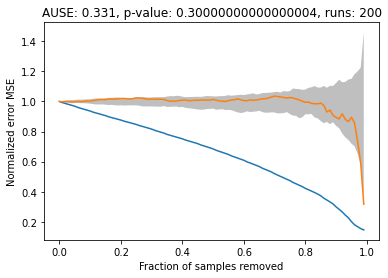

In [84]:
X, y = data3[data3.columns[:-2]], data3['label']
pred_probs, pred_variances, pred_labels = process_data(X, y)
permutation_test(pred_probs, pred_variances, pred_labels)